In [20]:
import os
path='/Users/tonglen/downloads/rub-co-occurrence-master_2/'
os.chdir(path)

os.getcwd()

'/Users/tonglen/Downloads/rub-co-occurrence-master_2'

In [21]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from os import path
from collections import Counter
from matplotlib import pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial import distance
from urllib.parse import urlencode
from urllib.request import urlretrieve

In [22]:
# Opening the queries as a dataframe - one query per row determined by a PFAM, INTERPRO ID or EC class.
queries_filename = 'uniprotKB_queries.csv'
queries_df = pd.read_csv(queries_filename, sep = '\t')
# Hack - pandas sets empty values to NaN which do not evaluate to False.
# Replace NaN with None which does evaluate to False.
queries_df[queries_df.isnull()] = None
#queries_df.where(queries_df.notnull(), other=None)
queries_df

,gene_name,pfam,interpro,EC,notes,Unnamed: 5,Unnamed: 6
0,rubisco_small,pf00101,None,None,None,None,None
1,FormIV,None,None,None,None,None,None
2,FormIIIb,None,None,None,None,None,None
3,FormIE,None,None,None,None,None,None
4,FormIC,None,None,None,None,None,None
5,FormIBc,None,None,None,None,None,None
6,FormIAq,None,None,None,None,None,None
7,FormIAc,None,None,None,None,None,None
8,FormIA_all,None,None,None,None,None,None
9,FormI_all,None,None,None,None,None,None


In [23]:
# Helper function for making an UniprotKB query string for their REST API.
# Must provide ONE of pfam, interpro or EC
def format_query_url(pfam=None, interpro=None, EC=None):
    base_url = 'https://www.uniprot.org/uniprot/?'
    columns = (  # columns we want to request
        'id,entry name,genes,genes(ORF),organism,organism-id,length,mass,sequence,ec,fragment,' +
        'comment(PATHWAY),annotation score,reviewed,' + 
        'feature(INTRAMEMBRANE),feature(TRANSMEMBRANE),database(INTERPRO),database(PFAM),database(PROSITE),' +
        'lineage(SUPERKINGDOM),lineage(PHYLUM),lineage(CLASS),lineage(ORDER),comment(COFACTOR),protein names'
    )
    
    # build the query in a manner that depends on the parameters supplied
    query_str = ''
    if pfam is not None:
        query_str = 'database:(type:pfam %s)' % pfam
    elif interpro is not None:
        query_str = 'database:(type:interpro %s)' % interpro
    elif EC is not None:
        query_str = 'ec:%s' % EC
    else:
        assert False, 'you suck, you didnt set any params for search.'
    
    # urlencode the query string and format the full URL.
    url_query = {'query': query_str,
                 'sort': 'score',
                 'columns': columns,
                 'format': 'tab'}
    encoded_query = urlencode(url_query)
    
    full_url = ''.join([base_url, encoded_query])
    return full_url

In [24]:
#mkdir ~/uniprotKB_downloads/

#  bciD, bchV: no corresponding proteomes found. 

# For each row in the dataframe
for row_id, row in queries_df.iterrows():
    # Determine if there is enough information to make a query
    # - need one of the three fields below.
    if not row.pfam and not row.interpro and not row.EC:
        print('No query, skipping')
        continue
            
    # Make the query
    q = format_query_url(pfam=row.pfam, interpro=row.interpro, EC=row.EC)
    print(row.gene_name)
    print('%s' % q)
    
    # Format the output filename
    out_fname = 'uniprotKB_downloads/%s.csv' % row.gene_name
    # read the file to this folder.
    
    # skip if output exists.
    if path.exists(out_fname):
        print('file exists, skipping')
        continue
    
    try:
        # Try to read the file from the Uniprot API into a local file.
        urlretrieve(q, out_fname)
    except Error as e:
        print(e)
        continue

rubisco_small
https://www.uniprot.org/uniprot/?query=database%3A%28type%3Apfam+pf00101%29&sort=score&columns=id%2Centry+name%2Cgenes%2Cgenes%28ORF%29%2Corganism%2Corganism-id%2Clength%2Cmass%2Csequence%2Cec%2Cfragment%2Ccomment%28PATHWAY%29%2Cannotation+score%2Creviewed%2Cfeature%28INTRAMEMBRANE%29%2Cfeature%28TRANSMEMBRANE%29%2Cdatabase%28INTERPRO%29%2Cdatabase%28PFAM%29%2Cdatabase%28PROSITE%29%2Clineage%28SUPERKINGDOM%29%2Clineage%28PHYLUM%29%2Clineage%28CLASS%29%2Clineage%28ORDER%29%2Ccomment%28COFACTOR%29%2Cprotein+names&format=tab
file exists, skipping
No query, skipping
No query, skipping
No query, skipping
No query, skipping
No query, skipping
No query, skipping
No query, skipping
No query, skipping
No query, skipping
No query, skipping
No query, skipping
No query, skipping
No query, skipping
sbpase
https://www.uniprot.org/uniprot/?query=ec%3A3.1.3.37&sort=score&columns=id%2Centry+name%2Cgenes%2Cgenes%28ORF%29%2Corganism%2Corganism-id%2Clength%2Cmass%2Csequence%2Cec%2Cfragment%2

In [25]:
# u gotta reformat the Mass column to get rid of the commas using R. Files in the uniprotKB_reformat folder.
filenames = dict((k, 'uniprotKB_downloads/%s.csv' % k) for k in queries_df.gene_name) #filenames is a dictionary of our markers
filenames

{'2pg_phosphatase': 'uniprotKB_downloads/2pg_phosphatase.csv',
 'FormIA_all': 'uniprotKB_downloads/FormIA_all.csv',
 'FormIAc': 'uniprotKB_downloads/FormIAc.csv',
 'FormIAq': 'uniprotKB_downloads/FormIAq.csv',
 'FormIBc': 'uniprotKB_downloads/FormIBc.csv',
 'FormIC': 'uniprotKB_downloads/FormIC.csv',
 'FormIE': 'uniprotKB_downloads/FormIE.csv',
 'FormII': 'uniprotKB_downloads/FormII.csv',
 'FormIII_all': 'uniprotKB_downloads/FormIII_all.csv',
 'FormIIIb': 'uniprotKB_downloads/FormIIIb.csv',
 'FormII_III': 'uniprotKB_downloads/FormII_III.csv',
 'FormII_all': 'uniprotKB_downloads/FormII_all.csv',
 'FormIV': 'uniprotKB_downloads/FormIV.csv',
 'FormI_all': 'uniprotKB_downloads/FormI_all.csv',
 'all_CA': 'uniprotKB_downloads/all_CA.csv',
 'bchG': 'uniprotKB_downloads/bchG.csv',
 'bchP': 'uniprotKB_downloads/bchP.csv',
 'bicA': 'uniprotKB_downloads/bicA.csv',
 'bmc_hexamer': 'uniprotKB_downloads/bmc_hexamer.csv',
 'bmc_pentamer': 'uniprotKB_downloads/bmc_pentamer.csv',
 'ccmM': 'uniprotKB_do

In [26]:
#path='/Users/tonglen/downloads/rub-co-occurrence-master_2/'
#os.chdir(path)

#os.getcwd()

#https://stackoverflow.com/questions/50722067/file-btrain-csv-does-not-exist-even-though-file-exist

#counts is adding a tick mark to org ID for every time there is an entry in our uniprot downloads. Paralogs with identical sequence are removed previously when Tree2Fasta output is merged and dereplicated prior to co-occurrence analysis.
counts = dict((gene_name, {}) for gene_name in filenames.keys())  #counts is a dictionary with key = gene_name and value = {}
counts

{'2pg_phosphatase': {},
 'FormIA_all': {},
 'FormIAc': {},
 'FormIAq': {},
 'FormIBc': {},
 'FormIC': {},
 'FormIE': {},
 'FormII': {},
 'FormIII_all': {},
 'FormIIIb': {},
 'FormII_III': {},
 'FormII_all': {},
 'FormIV': {},
 'FormI_all': {},
 'all_CA': {},
 'bchG': {},
 'bchP': {},
 'bicA': {},
 'bmc_hexamer': {},
 'bmc_pentamer': {},
 'ccmM': {},
 'ccmO': {},
 'chl_A': {},
 'csos2': {},
 'csosCA': {},
 'cupABS': {},
 'dabA': {},
 'glpX': {},
 'hps': {},
 'phi': {},
 'prk': {},
 'prokaryotic_CA': {},
 'psbU': {},
 'rubisco_large': {},
 'rubisco_small': {},
 'sbpase': {},
 'sbtA': {}}

In [33]:
superkingdoms = {}  #define new empty dictionaries
organisms = {}
phyla = {}
classes = {}
orders = {}

#default_value = "No Org ID"

for gene_name, fname in filenames.items(): #gene_name is marker keys (lg_rub, etc); fname is new variable as filename values (items) in filenames dict
    if not path.exists(fname):
        continue 
        
    gene_df = pd.read_csv(fname, dtype={"Organism ID": object}, sep = None, header = 0, names = ["Entry", "Entry name", "Gene names", "Gene names  (ORF )", "Organism", "Organism ID", "Length", "Mass", "Sequence", "EC number", "Fragment", "Pathway", "Annotation", "Status", "Intramembrane", "Transmembrane", "Cross reference (INTERPRO)", "Cross reference (PFAM)", "Cross reference (PROSITE)", "Taxonomic lineage (SUPERKINGDOM)", "Taxonomic lineage (PHYLUM)", "Taxonomic lineage (CLASS)", "Taxonomic lineage (ORDER)", "Cofactor", "Protein names"]) #renaming col headers is necessary otherwise there is a key error for some reason  
    #print(gene_df)
    #print(gene_df.iloc[5])

 

    organism_ids = gene_df["Organism ID"]  
    #print(organism_ids)

    #organism_ids = gene_df.get('Organism ID', None)
    #print(organism_ids)
    
    counts_dict = dict(Counter(organism_ids))   #counts_dict is a dictionary, Counter is a python function that counts items in the dictionary
    #print(counts_dict)  
    
    # save the superkingdom data as we go
    for _, row in gene_df.iterrows():       #for each individual row:
        #org_id = row.get('Organism ID', None)
        org_id = row["Organism ID"]   #assign variables to vector for each column of data in gene_df
        #org_id = row.iloc[5]
        #print(org_id)
        #org = row.get('Organism', None)
        org = row['Organism']   
        #org = row.iloc[4]
        #sup = row.get('Taxonomic lineage (SUPERKINGDOM)', None)
        sup = row['Taxonomic lineage (SUPERKINGDOM)']
        #phy = row.get('Taxonomic lineage (PHYLUM)', None)
        phy = row['Taxonomic lineage (PHYLUM)']
        #cla = row.get('Taxonomic lineage (CLASS)', None)
        cla = row['Taxonomic lineage (CLASS)']
        #orde = row.get('Taxonomic lineage (ORDER)', None)
        orde = row['Taxonomic lineage (ORDER)']
      
        
        superkingdoms[org_id] = sup  #assign data point from gene_df column, sup, to key in the superkingdoms{} dictionary. 
        organisms[org_id] = org      #each dictionary gets its own column of values
        phyla[org_id] = phy          #nothing happens with these dictionaries until the next cell 
        classes[org_id] = cla
        orders[org_id] = orde 
        #entries[org_id] = ent
        
        
    #counts_dict['superkingdom'] = gene_df.get('Taxonomic lineage (SUPERKINGDOM)', None)
    counts_dict['superkingdom'] = gene_df['Taxonomic lineage (SUPERKINGDOM)']  #counts_dict superkingdom key is assigned column from gene_df
    #print (counts_dict)
    #counts_dict['entry'] = gene_df['Entry']
    #do i need to put the other phyla info into counts_dict as well?
    counts[gene_name] = counts_dict #original counts dict had gene_name keys; no values.
                                    # now, the counts_dict dictionary {org_ids: replicates} becomes the values in counts
                                    # so, counts.dict is {gene_name, {org_ids:replicates}}
counts_df = pd.DataFrame(counts)   #convert counts dictionary with superkingdom info by org ID into dataframe 

#print (counts_dict)    
#print (counts[gene_name])
#sup
counts_df.to_csv('uniprotKB_downloads/data_2/counts_df.csv') 

/Users/tonglen/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  del sys.path[0]


In [34]:
#counts_df = pd.DataFrame(counts)

# Boolean logic for Calvin cycle
rub_large = counts_df.rubisco_large.notnull()  #original CBB boolean included all rub_lg
sbpase = counts_df.sbpase.notnull()
prk = counts_df.prk.notnull()
glpX = counts_df.glpX.notnull()  #second EC class attributed to sedoheptulose 1,7-bisphostphate phosphatase
sbpase_all = np.logical_or(glpX, sbpase)
form1 = counts_df.FormI_all.notnull() #returns df with True in FormI_all row containing values, False if NaN
form2 = counts_df.FormII_all.notnull()
cbb_rub = np.logical_or(form1, form2) #revised CBB boolean only uses FI and FII rubisco, not III or IV
calvin = np.logical_and(np.logical_and(cbb_rub, sbpase_all), prk)

# Boolean logic for ribulose monophosphate/hexulose monophosphate pathways
#hps = counts_df.hps.notnull()
#phi = counts_df.phi.notnull()
#rump_or_hex = np.logical_and(hps, phi)

# Boolean logic for alpha and beta csome
ccmM = counts_df.ccmM.notnull()
#ccmO = counts_df.ccmO.notnull()
csos2 = counts_df.csos2.notnull()
csosCA = counts_df.csosCA.notnull()
bmc_hex = counts_df.bmc_hexamer.notnull()
bmc_pent = counts_df.bmc_pentamer.notnull()
bmcs = np.logical_and(bmc_hex, bmc_pent)
alpha_csome = np.logical_and(np.logical_and(csos2, csosCA), bmcs)
beta_csome = np.logical_and(ccmM, bmcs)
any_csome = np.logical_or(alpha_csome, beta_csome)

# Boolean logic for ci transport
bicA = counts_df.bicA.notnull()
sbtA = counts_df.sbtA.notnull()
cupABS = counts_df.cupABS.notnull()
dabA = counts_df.dabA.notnull()
ci_transport = np.logical_or(dabA, np.logical_or(cupABS, np.logical_or(sbtA, bicA)))

# Boolean logic for O2 resp. This will be replaced with OxyPhen data.
#cyt_c_ox = counts_df.cyt_c_ox.notnull()
#quinol_ox = counts_df.quinol_ox.notnull()
#O2_resp = np.logical_or(cyt_c_ox, quinol_ox)

# Boolean logic for all bacteriochlorophyll
chl_A = counts_df.chl_A.notnull()
bchG = counts_df.bchG.notnull()
bchP = counts_df.bchP.notnull()
chl_synth = np.logical_or(chl_A, np.logical_or(bchG, bchP))

# Boolean logic for cyano markers
psbU = counts_df.psbU.notnull()
Cyanob = np.logical_and(psbU, chl_A)

# Add the pathway annotations and superkingdom, phylum, class, order, entry, to the dataframe
counts_df['calvin_cycle'] = calvin
#counts_df['rump_or_hex'] = rump_or_hex
counts_df['organism'] = [organisms.get(org_id) for org_id in counts_df.index]
counts_df['superkingdom'] = [superkingdoms.get(org_id) for org_id in counts_df.index] #define new 'superkingdom' column in counts_df that contains the vector of info (previous cell) from superkingdoms dictionary   
counts_df['phylum'] = [phyla.get(org_id) for org_id in counts_df.index]
counts_df['class'] = [classes.get(org_id) for org_id in counts_df.index]
counts_df['order'] = [orders.get(org_id) for org_id in counts_df.index]
counts_df['sbpase_all'] = sbpase_all
#counts_df['entry'] = [entries.get(org_id) for org_id in counts_df.index] #doesn't work b/c it only lists one entry per orgID


counts_df['alpha_csome'] = alpha_csome  #assigning vector of data to new column in counts_df
counts_df['beta_csome'] = beta_csome
counts_df['any_csome'] = any_csome
counts_df['any_csome'] = any_csome
counts_df['ci_transport'] = ci_transport
#counts_df['O2_resp'] = O2_resp
counts_df['Cyanob'] = Cyanob
counts_df['chl_synth'] = chl_synth

counts_df.to_csv('uniprotKB_downloads/data_2/counts_df.csv') 

counts_df


,2pg_phosphatase,FormIA_all,FormIAc,FormIAq,FormIBc,FormIC,FormIE,FormII,FormIII_all,FormIIIb,...,phylum,class,order,sbpase_all,alpha_csome,beta_csome,any_csome,ci_transport,Cyanob,chl_synth
100,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Proteobacteria,Alphaproteobacteria,Rhizobiales,True,False,False,False,True,False,False
1000287,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Rhodophyta,Florideophyceae,Halymeniales,False,False,False,False,False,False,False
1000412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Streptophyta,Magnoliopsida,Asparagales,False,False,False,False,False,False,False
1000413,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Streptophyta,Magnoliopsida,Sapindales,False,False,False,False,True,False,True
1000414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Streptophyta,Magnoliopsida,Asparagales,False,False,False,False,False,False,False
1000415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Streptophyta,Magnoliopsida,Rosales,False,False,False,False,False,False,False
1000416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Streptophyta,Magnoliopsida,Poales,False,False,False,False,False,False,False
1000418,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Streptophyta,Magnoliopsida,Lamiales,False,False,False,False,False,False,False
1000420,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Streptophyta,Magnoliopsida,Malpighiales,False,False,False,False,False,False,False
1000422,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Streptophyta,Magnoliopsida,Fabales,False,False,False,False,False,False,False


In [35]:
# Grab the subset of the data for which there is an identified Rubisco isoform. 
# since no metagen and environmental sample prokaryotes are filtered out from annotated rubisco csv, then don't need to worry about masking out 
# environmental samples from the rest of the .csv files
# rubisco files filterd by "Fragment" column, and also by length, to remove partial rubisco sequences from co-occurrence analysis


form1 = counts_df.FormI_all.notnull()
form2 = counts_df.FormII_all.notnull()
form3 = counts_df.FormIII_all.notnull()
form4 = counts_df.FormIV.notnull()

f1_or_2 = np.logical_or(form1, form2)
f3_or_4 = np.logical_or(form3, form4)  #add back form4 as needed
has_identified_rub = np.logical_or(f1_or_2, f3_or_4)  #add back f3_or_f4 as needed if FormIV is added back

subset_df = counts_df[has_identified_rub].copy()
#print('Everyone has Rubisco LSU: ', (subset_df.rubisco_large > 0).all())

subset_df

,2pg_phosphatase,FormIA_all,FormIAc,FormIAq,FormIBc,FormIC,FormIE,FormII,FormIII_all,FormIIIb,...,phylum,class,order,sbpase_all,alpha_csome,beta_csome,any_csome,ci_transport,Cyanob,chl_synth
1036672,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,Proteobacteria,Betaproteobacteria,Burkholderiales,True,False,False,False,True,False,False
1036673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Bacilli,Bacillales,False,False,False,False,True,False,False
1037409,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,Proteobacteria,Alphaproteobacteria,Rhizobiales,False,False,False,False,False,False,False
1038856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Bacilli,Bacillales,True,False,False,False,True,False,False
1041930,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Euryarchaeota,Methanomicrobia,Methanocellales,False,False,False,False,False,False,False
1042163,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Bacilli,Bacillales,False,False,False,False,True,False,False
1042877,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,...,Euryarchaeota,Thermococci,Thermococcales,True,False,False,False,False,False,False
1042878,4,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,Proteobacteria,Betaproteobacteria,Burkholderiales,True,False,False,False,True,False,False
1048260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nitrospirae,Nitrospira,Nitrospirales,True,False,False,False,True,False,False
1048396,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,...,Euryarchaeota,Halobacteria,Haloferacales,True,False,False,False,True,False,False


In [36]:
# mask out any Eukaryotes and convert the data to presence/absense
#mask = subset_df.superkingdom != 'Eukaryota'
#prokaryote_df = subset_df[mask]


prokaryote_df = subset_df
prokaryote_df

,2pg_phosphatase,FormIA_all,FormIAc,FormIAq,FormIBc,FormIC,FormIE,FormII,FormIII_all,FormIIIb,...,phylum,class,order,sbpase_all,alpha_csome,beta_csome,any_csome,ci_transport,Cyanob,chl_synth
1036672,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,Proteobacteria,Betaproteobacteria,Burkholderiales,True,False,False,False,True,False,False
1036673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Bacilli,Bacillales,False,False,False,False,True,False,False
1037409,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,Proteobacteria,Alphaproteobacteria,Rhizobiales,False,False,False,False,False,False,False
1038856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Bacilli,Bacillales,True,False,False,False,True,False,False
1041930,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Euryarchaeota,Methanomicrobia,Methanocellales,False,False,False,False,False,False,False
1042163,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Bacilli,Bacillales,False,False,False,False,True,False,False
1042877,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,...,Euryarchaeota,Thermococci,Thermococcales,True,False,False,False,False,False,False
1042878,4,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,Proteobacteria,Betaproteobacteria,Burkholderiales,True,False,False,False,True,False,False
1048260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nitrospirae,Nitrospira,Nitrospirales,True,False,False,False,True,False,False
1048396,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,...,Euryarchaeota,Halobacteria,Haloferacales,True,False,False,False,True,False,False


In [37]:
#it has a crazy extra row of text at the bottom, don't know where it's coming from.

fix = len(prokaryote_df.index)  # delete wacky last row that is full of multi-line text for some reason?!?

prokaryote_df = prokaryote_df[0:(fix-1)]

prokaryote_df.to_csv('uniprotKB_downloads/data_2/prok_counts.csv')  #sbpase_all is not in this file

prokaryote_df

,2pg_phosphatase,FormIA_all,FormIAc,FormIAq,FormIBc,FormIC,FormIE,FormII,FormIII_all,FormIIIb,...,phylum,class,order,sbpase_all,alpha_csome,beta_csome,any_csome,ci_transport,Cyanob,chl_synth
1036672,1,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,Proteobacteria,Betaproteobacteria,Burkholderiales,True,False,False,False,True,False,False
1036673,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Bacilli,Bacillales,False,False,False,False,True,False,False
1037409,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,Proteobacteria,Alphaproteobacteria,Rhizobiales,False,False,False,False,False,False,False
1038856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Bacilli,Bacillales,True,False,False,False,True,False,False
1041930,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Euryarchaeota,Methanomicrobia,Methanocellales,False,False,False,False,False,False,False
1042163,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Firmicutes,Bacilli,Bacillales,False,False,False,False,True,False,False
1042877,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,...,Euryarchaeota,Thermococci,Thermococcales,True,False,False,False,False,False,False
1042878,4,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,...,Proteobacteria,Betaproteobacteria,Burkholderiales,True,False,False,False,True,False,False
1048260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Nitrospirae,Nitrospira,Nitrospirales,True,False,False,False,True,False,False
1048396,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,...,Euryarchaeota,Halobacteria,Haloferacales,True,False,False,False,True,False,False


In [38]:
# isnull() returns false for NaN which is what we have for empty counts.
binary_prokaryote_df = ~prokaryote_df.isnull()

# special columns should not be binarized, just kept as is.
# that's because they are already binary and don't have NaN for nulls.
special_cols = ['calvin_cycle', 'superkingdom', 'organism', 'Cyanob', 'chl_synth',
                'alpha_csome', 'beta_csome', 'any_csome', 'ci_transport', 'phylum', 'class', 'order', 'sbpase_all']  #'O2 resp removed
binary_prokaryote_df[special_cols] = prokaryote_df[special_cols]
#binary_prokaryote_df.head()

binary_prokaryote_df.to_csv('uniprotKB_downloads/data_2/binary_prokaryote_df.csv')

(binary_prokaryote_df > 0).sum()

2pg_phosphatase    494
FormIA_all          74
FormIAc             47
FormIAq             23
FormIBc             65
FormIC              88
FormIE              16
FormII              37
FormIII_all        117
FormIIIb            81
FormII_III           7
FormII_all          44
FormIV             470
FormI_all          255
all_CA             477
bchG               161
bchP                38
bicA               651
bmc_hexamer        190
bmc_pentamer       188
ccmM                70
ccmO               178
chl_A               54
csos2               57
csosCA              63
cupABS              84
dabA               177
glpX               587
hps                100
phi                 35
prk                332
prokaryotic_CA     661
psbU                85
rubisco_large      862
rubisco_small      310
sbpase              93
sbtA               162
calvin_cycle       243
organism           886
superkingdom       886
phylum             886
class              886
order              886
sbpase_all 

In [39]:
# Calculation the pearson correlations of the columns of the binarized data.
cols_to_drop = ['csos2', 'csosCA', 'ccmM', 'ccmO', #'acRAF', 'ccmN', 'quinol_ox', 'cyt_c_ox', were removed, 
                'sbpase', 'prk', 'glpX', 'sbpase_all',
                'sbtA', 'bicA', 'cupABS', 'dabA', 'bchG', 'bchP',
                'hps', 'phi', 'prokaryotic_CA', 'all_CA',
                'bmc_pentamer', 'bmc_hexamer', 'organism', 'superkingdom', 
                'class', 'order', 'phylum','rubisco_large'
               ]

for_corr = binary_prokaryote_df.drop(cols_to_drop, axis=1)
corr = for_corr.corr()

pretty_colnames = {
    'rubisco_small': 'Rub.SSU',
    'rubisco_large': 'Rub.LSU',
    'prk': 'Prk',
    'sbpase': 'SBPase',
    'FormI_all': 'Rub.FI_all',
    'FormIA_all': 'Rub.FIA_all',
    'FormIAc' : 'Rub.IAc',
    'FormIAq' : 'Rub.IAq',
    'FormII': 'Rub.FII',
    'FormII_III': 'Rub.FII_III',
    'FormII_all': 'Rub.FII_all',
    'FormIII_all': 'Rub.FIII_all',
    'FormIV': 'Rub.FIV_all',
    'FormIBc' : 'Rub.IB',
    'FormIC' : 'Rub.IC',
    'FormIE' : 'Rub.IE',
    'FormIIIb' : 'Rub.IIIb',
    'FormIIIc' : 'Rub.IIIc',
#    'FormIIIa': 'Rub.IIIa',
    '2pg_phosphatase': '2PGase',
#    'cyt_c_ox': 'Cyt. C oxidase',
    'chl_synth': 'All BactChloroph.',
    'calvin_cycle': 'CBB cycle',
#    'rump_or_hex': 'RUMP/HMP Pathways',
    'alpha_csome': '$\\alpha$-csome',
    'beta_csome': '$\\beta$-csome',
    'any_csome': 'Any Csome',
    'ci_transport': '$C_i$ Transport',
    'chl_A': 'BactChloroph. A',
    'psbU': 'psbU',
    'Cyanob': 'Cyanob.'
    }
#    'O2_resp': 'O2 Resp',
#    'quinol_ox': 'Quinol Oxidase'}

ticks = [pretty_colnames[c] for c in corr.index]
corr

,2pg_phosphatase,FormIA_all,FormIAc,FormIAq,FormIBc,FormIC,FormIE,FormII,FormIII_all,FormIIIb,...,chl_A,psbU,rubisco_small,calvin_cycle,alpha_csome,beta_csome,any_csome,ci_transport,Cyanob,chl_synth
2pg_phosphatase,1.000000,0.063577,-0.042639,0.145425,-0.228712,0.250228,-0.066912,0.129164,0.233355,0.235260,...,-0.067521,-0.288529,0.143683,0.104481,-0.006271,-0.252976,-0.200379,-0.063769,-0.122209,-0.073866
FormIA_all,0.063577,1.000000,0.784025,0.540780,-0.084942,-0.100248,-0.040939,-0.063021,-0.117752,-0.095760,...,0.110666,0.095589,0.411498,0.353908,0.700043,-0.088418,0.416727,0.137854,0.011150,0.163770
FormIAc,-0.042639,0.784025,1.000000,-0.038639,-0.066597,-0.078597,-0.032097,-0.049410,-0.092320,-0.075078,...,0.171248,0.162289,0.322625,0.351146,0.878259,-0.069322,0.555057,0.116167,0.039218,0.235465
FormIAq,0.145425,0.540780,-0.038639,1.000000,-0.045935,-0.054212,-0.022139,-0.034080,-0.063678,-0.051785,...,-0.041590,-0.053180,0.222530,0.090555,-0.012583,-0.047815,-0.045774,0.062181,-0.030562,-0.032256
FormIBc,-0.228712,-0.084942,-0.066597,-0.045935,1.000000,-0.093438,-0.038158,-0.058740,-0.109753,-0.089254,...,0.380679,0.849059,0.383544,0.370382,-0.072388,0.928590,0.669390,0.138102,0.545664,0.533397
FormIC,0.250228,-0.100248,-0.078597,-0.054212,-0.093438,1.000000,-0.045034,-0.069325,-0.129530,-0.105338,...,-0.068827,-0.108177,0.405185,0.447144,-0.054154,-0.097262,-0.112906,0.086663,-0.062168,-0.070036
FormIE,-0.066912,-0.040939,-0.032097,-0.022139,-0.038158,-0.045034,1.000000,-0.028310,-0.052897,-0.043017,...,-0.034549,-0.044177,0.167083,0.125609,-0.034888,-0.039720,-0.054962,0.023702,-0.025388,-0.049372
FormII,0.129164,-0.063021,-0.049410,-0.034080,-0.058740,-0.069325,-0.028310,1.000000,-0.081429,-0.066220,...,0.017568,-0.068005,0.012471,0.213121,0.063208,-0.061144,-0.003567,0.059667,-0.039081,-0.025016
FormIII_all,0.233355,-0.117752,-0.092320,-0.063678,-0.109753,-0.129530,-0.052897,-0.081429,1.000000,0.813233,...,-0.099372,-0.127064,-0.286154,-0.239788,-0.100348,-0.114244,-0.158086,-0.575573,-0.073022,-0.013841
FormIIIb,0.235260,-0.095760,-0.075078,-0.051785,-0.089254,-0.105338,-0.043017,-0.066220,0.813233,1.000000,...,-0.080813,-0.103333,-0.232710,-0.195003,-0.081607,-0.092907,-0.128560,-0.517580,-0.059384,-0.125681


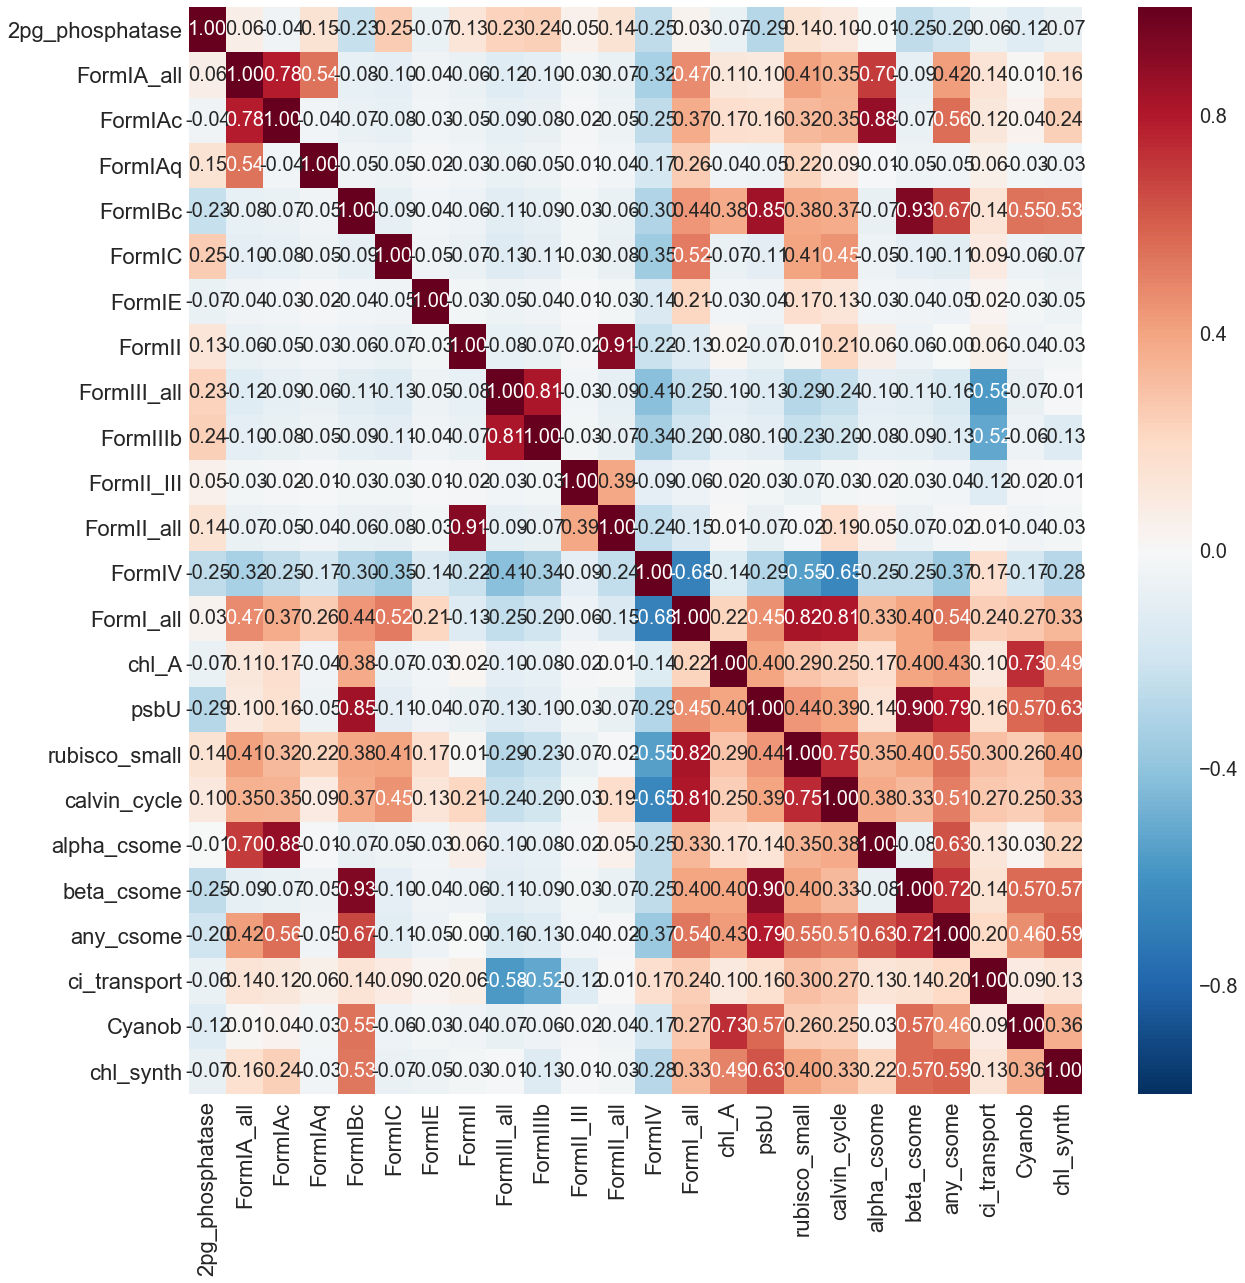

In [40]:
## plot a correlation heatmap
#fig = plt.figure(figsize=(20,20))
#sns.heatmap(corr, annot=True, annot_kws={'fontsize': 20}, fmt='.2f')
#plt.xticks(fontsize=22)
#plt.yticks(fontsize=22)
#plt.show()

# plot a correlation heatmap
fig = plt.figure(figsize=(20,20))
sns.set(font_scale=2)
sns.heatmap(corr, annot=True, annot_kws={'fontsize': 20}, fmt='.2f') #, cmap='RdBu_r', center=0.0) changed to fix column order; not sure why this is happening

#tickrange = np.arange(len(ticks)) + 0.5
#plt.xticks(tickrange, ticks, fontsize=22)
#plt.yticks(tickrange, ticks, fontsize=22, rotation='horizontal')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig("pearson_heatmap.png", dpi=600)

plt.show()

In [58]:
# calculate p-values

from scipy.stats import pearsonr
def calculate_pvalues(df):
    df = df._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

In [59]:
stats_df = calculate_pvalues(for_corr)
stats_df  #prints dataframe of p-values corresponding to the pearson corr coeff of co-occurrence heatmap

,2pg_phosphatase,FormIA_all,FormIAc,FormIAq,FormIBc,FormIC,FormIE,FormII,FormIII_all,FormIIIb,...,chl_A,psbU,rubisco_small,calvin_cycle,alpha_csome,beta_csome,any_csome,ci_transport,Cyanob,chl_synth
2pg_phosphatase,0,0.1113,0.1298,0,0,0,0.0325,0.0003,0,0,...,0.0227,0,0.0003,0.0087,0.6533,0,0,0.0003,0.0001,0.0126
FormIA_all,0.1113,0,0,0,0.0114,0.0028,0.2235,0.0608,0.0004,0.0043,...,0.001,0.0044,0,0,0,0.0085,0,0.0005,0.7403,0
FormIAc,0.1298,0,0,0.2506,0.0475,0.0193,0.3399,0.1417,0.006,0.0254,...,0,0,0,0,0,0.0391,0,0.0012,0.2436,0
FormIAq,0,0,0.2506,0,0.1719,0.1068,0.5105,0.3109,0.0581,0.1235,...,0.2162,0.1137,0,0.0097,0.7084,0.155,0.1734,0.2609,0.3635,0.3318
FormIBc,0,0.0114,0.0475,0.1719,0,0.0054,0.2565,0.0806,0.0011,0.0079,...,0,0,0,0,0.0312,0,0,0.0001,0,0
FormIC,0,0.0028,0.0193,0.1068,0.0054,0,0.1805,0.0391,0.0001,0.0017,...,0.0405,0.0013,0,0,0.1072,0.0038,0.0008,0.0001,0.0644,0.0669
FormIE,0.0325,0.2235,0.3399,0.5105,0.2565,0.1805,0,0.4,0.1156,0.2008,...,0.3043,0.1889,0,0,0.2996,0.2376,0.1021,0.5962,0.4504,0.1398
FormII,0.0003,0.0608,0.1417,0.3109,0.0806,0.0391,0.4,0,0.0153,0.0488,...,0.6015,0.043,0.7784,0,0.06,0.0689,0.9156,0.125,0.2452,0.4476
FormIII_all,0,0.0004,0.006,0.0581,0.0011,0.0001,0.1156,0.0153,0,0,...,0.0031,0.0001,0,0,0.0028,0.0007,0,0,0.0298,0.8413
FormIIIb,0,0.0043,0.0254,0.1235,0.0079,0.0017,0.2008,0.0488,0,0,...,0.0161,0.0021,0,0,0.0151,0.0056,0.0001,0,0.0773,0.0005


In [60]:
#need to mod this code to calculate bonferroni as dependent var

#and here's a nice way to show the p-values and r values in one fig:

# https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance

# If a p-value is less than 0.05, it is flagged with one star (*). 
# If a p-value is less than 0.01, it is flagged with two stars (**). 
# If a p-value is less than 0.001, it is flagged with three stars (***).

rho_df = for_corr.corr()
rho_df = rho_df.round(2)
pval_df = calculate_pvalues(for_corr) # toto_tico's answer
# create three masks
r1 = rho_df.applymap(lambda x: '{}*'.format(x))
r2 = rho_df.applymap(lambda x: '{}**'.format(x))
r3 = rho_df.applymap(lambda x: '{}***'.format(x))
# apply them where appropriate
rho_df = rho_df.mask(pval_df<=0.0002,r1)
rho_df = rho_df.mask(pval_df<=0.00002,r2)
rho_df = rho_df.mask(pval_df<=0.000002,r3)  # p-value of 0.05 with Bonferroni correction
#Bonferroni correction = alpha / num comparisons. alpha = 0.05. Num comparisons = 16rows x 16 cols/2.
#bonferroni correction = 0.05 / 256 = 0.00019.
rho_df

,2pg_phosphatase,FormIA_all,FormIAc,FormIAq,FormIBc,FormIC,FormIE,FormII,FormIII_all,FormIIIb,...,chl_A,psbU,rubisco_small,calvin_cycle,alpha_csome,beta_csome,any_csome,ci_transport,Cyanob,chl_synth
2pg_phosphatase,1.0***,0.05,-0.05,0.14***,-0.24***,0.28***,-0.07,0.12,0.23***,0.24***,...,-0.08,-0.3***,0.12,0.09,-0.02,-0.26***,-0.22***,-0.12,-0.13*,-0.08
FormIA_all,0.05,1.0***,0.78***,0.54***,-0.08,-0.1,-0.04,-0.06,-0.12,-0.1,...,0.11,0.1,0.41***,0.35***,0.7***,-0.09,0.42***,0.12,0.01,0.16***
FormIAc,-0.05,0.78***,1.0***,-0.04,-0.07,-0.08,-0.03,-0.05,-0.09,-0.08,...,0.17***,0.16***,0.32***,0.34***,0.88***,-0.07,0.56***,0.11,0.04,0.23***
FormIAq,0.14***,0.54***,-0.04,1.0***,-0.05,-0.05,-0.02,-0.03,-0.06,-0.05,...,-0.04,-0.05,0.22***,0.09,-0.01,-0.05,-0.05,0.04,-0.03,-0.03
FormIBc,-0.24***,-0.08,-0.07,-0.05,1.0***,-0.09,-0.04,-0.06,-0.11,-0.09,...,0.38***,0.85***,0.38***,0.36***,-0.07,0.93***,0.67***,0.13*,0.55***,0.53***
FormIC,0.28***,-0.1,-0.08,-0.05,-0.09,1.0***,-0.05,-0.07,-0.13*,-0.11,...,-0.07,-0.11,0.45***,0.49***,-0.05,-0.1,-0.11,0.13*,-0.06,-0.06
FormIE,-0.07,-0.04,-0.03,-0.02,-0.04,-0.05,1.0***,-0.03,-0.05,-0.04,...,-0.03,-0.04,0.18***,0.14***,-0.03,-0.04,-0.05,0.02,-0.03,-0.05
FormII,0.12,-0.06,-0.05,-0.03,-0.06,-0.07,-0.03,1.0***,-0.08,-0.07,...,0.02,-0.07,0.01,0.21***,0.06,-0.06,-0,0.05,-0.04,-0.03
FormIII_all,0.23***,-0.12,-0.09,-0.06,-0.11,-0.13*,-0.05,-0.08,1.0***,0.81***,...,-0.1,-0.13*,-0.29***,-0.24***,-0.1,-0.11,-0.16***,-0.61***,-0.07,-0.01
FormIIIb,0.24***,-0.1,-0.08,-0.05,-0.09,-0.11,-0.04,-0.07,0.81***,1.0***,...,-0.08,-0.1,-0.24***,-0.2***,-0.08,-0.09,-0.13*,-0.54***,-0.06,-0.12


In [44]:
rho_df.to_csv('uniprotKB_downloads/data_2/revised_rho_df.csv')  

In [64]:
#    :^D 

############## calculate conditional probabilities! :^D So proud lol //////////////////////////////////////////////////////





# requires calculating the intersections (number of orgs) that have both marker A and marker B
#make a practice dataframe. the negative values serve as "NaN" for orgs that don't have that marker. Each row is Org.

#prokaryote_df.head()  #caution: slightly different file than binary_prokaryote.df, used to calculate pearson

cols_to_drop = ['csos2', 'csosCA', 'ccmM', 'ccmO', #'acRAF', 'ccmN', 'quinol_ox', 'cyt_c_ox', were removed, 
                'sbpase', 'prk', 'glpX', 'sbpase_all',
                'sbtA', 'bicA', 'cupABS', 'dabA', 'bchG', 'bchP',
                'hps', 'phi', 'prokaryotic_CA', 'all_CA',
                'bmc_pentamer', 'bmc_hexamer', 'organism', 'superkingdom', 
                'class', 'order', 'phylum','rubisco_large'
               ]

prokaryote_markers_df = prokaryote_df.drop(cols_to_drop, axis=1) #create list of counts per org ID by markers of interest

prokaryote_markers_df.head(20)
prokaryote_markers_df.to_csv('uniprotKB_downloads/data_2/prok_markers_df.csv')  #wow something truly wacky happened, the last row is full of the superkingdom data

prokaryote_markers_df


FileNotFoundError: [Errno 2] No such file or directory: 'uniprotKB_downloads/data_2/prok_markers_df.csv'

In [125]:
#fix = len(prokaryote_markers_df.index)  # delete wacky last row that is full of multi-line text for some reason?!?
#prok_markers_df.csv
#prokaryote_markers_df = prokaryote_markers_df[0:(fix-1)]
#len(prokaryote_markers_df.index) 
#prokaryote_markers_df.to_csv('uniprotKB_downloads/data_2/prok_markers_df.csv')  #looks right i guess?

In [64]:
pretty_colnames = {
    'rubisco_small': 'Rub.SSU',
    'rubisco_large': 'Rub.LSU',
    'prk': 'Prk',
    'sbpase': 'SBPase',
    'FormI_all': 'Rub.FI_all',
    'FormIA_all': 'Rub.FIA_all',
    'FormIAc' : 'Rub.IAc',
    'FormIAq' : 'Rub.IAq',
    'FormII': 'Rub.FII',
    'FormII_III': 'Rub.FII_III',
    'FormII_all': 'Rub.FII_all',
    'FormIII_all': 'Rub.FIII_all',
    'FormIV': 'Rub.FIV_all',
    'FormIBc' : 'Rub.IB',
    'FormIC' : 'Rub.IC',
    'FormIE' : 'Rub.IE',
    'FormIIIb' : 'Rub.IIIb',
    'FormIIIc' : 'Rub.IIIc',
#    'FormIIIa': 'Rub.IIIa',
    '2pg_phosphatase': '2PGase',
#    'cyt_c_ox': 'Cyt. C oxidase',
    'chl_synth': 'All BactChloroph.',
    'calvin_cycle': 'CBB cycle',
#    'rump_or_hex': 'RUMP/HMP Pathways',
    'alpha_csome': '$\\alpha$-csome',
    'beta_csome': '$\\beta$-csome',
    'any_csome': 'Any Csome',
    'ci_transport': '$C_i$ Transport',
    'chl_A': 'BactChloroph. A',
    'psbU': 'psbU',
    'Cyanob': 'Cyanob.'
    }

ticks = [pretty_colnames[c] for c in prokaryote_markers_df.columns]  


markers = ticks

print(markers)
print(ticks)
#head.prokaryote_df()

['2PGase', 'Rub.FIA_all', 'Rub.IAc', 'Rub.IAq', 'Rub.IB', 'Rub.IC', 'Rub.IE', 'Rub.FII', 'Rub.FIII_all', 'Rub.IIIb', 'Rub.FII_III', 'Rub.FII_all', 'Rub.FIV_all', 'Rub.FI_all', 'BactChloroph. A', 'psbU', 'Rub.SSU', 'CBB cycle', '$\\alpha$-csome', '$\\beta$-csome', 'Any Csome', '$C_i$ Transport', 'Cyanob.', 'All BactChloroph.']
['2PGase', 'Rub.FIA_all', 'Rub.IAc', 'Rub.IAq', 'Rub.IB', 'Rub.IC', 'Rub.IE', 'Rub.FII', 'Rub.FIII_all', 'Rub.IIIb', 'Rub.FII_III', 'Rub.FII_all', 'Rub.FIV_all', 'Rub.FI_all', 'BactChloroph. A', 'psbU', 'Rub.SSU', 'CBB cycle', '$\\alpha$-csome', '$\\beta$-csome', 'Any Csome', '$C_i$ Transport', 'Cyanob.', 'All BactChloroph.']


In [65]:
#make NaN and False = 0; True = 1

#prokaryote_df.head(20)
df = prokaryote_markers_df  #shorten name of prokaryote_df

df.fillna(0, inplace=True)  #convert NaN to 0

#df.replace('False', 0, inplace=True)
df *= 1  #converts bool true and false to 0 and 1, lol so simple

#print(df.dtypes)
df.head(20)

,2pg_phosphatase,FormIA_all,FormIAc,FormIAq,FormIBc,FormIC,FormIE,FormII,FormIII_all,FormIIIb,...,chl_A,psbU,rubisco_small,calvin_cycle,alpha_csome,beta_csome,any_csome,ci_transport,Cyanob,chl_synth
1036672,1,0,0,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1036673,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1037409,1,0,0,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1038856,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1041930,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1042163,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1042877,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1042878,4,0,0,0,0,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,0
1048260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1048396,1,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0


In [66]:
#get num rowns and num cols of data frame as list of integers:

rows = [i for i in range(df.shape[0])]
cols = [i for i in range(df.shape[1])]
print (len(rows))
print (len(cols))

#print (len(df[df.iloc[:,(denom)]>0]))

#the number of rows only use df.shape[0] and for the number of columns only use: df.shape[1]

886
24


In [67]:
#troubleshoot 
#denom = 0
#df[df.iloc[:,0]>0]
#test = df[df.iloc[:,0]>0]  #gives all of the rows in the first column. index location.
#test = df[df.iloc[:,0]>0]  #gives error str vs int comparison.
#print(test)

#create an empty dataframe with num of rows and columns equal to the number of markers
#df = pandas.DataFrame(columns=["id", "name", "score", "height", "weight"], dtypes=[int, str, int, float, float], index_column="id")
condProb_df = pd.DataFrame(columns = markers, index = markers, dtype = float)  
#condProb_df.dtypes #gotta be floats to make a heatmap of them; default is object datatype

In [68]:
num = 0  #counter for numerator column; numerator is intersection of two markers
denom = 0  #counter for denominator column; denominator is conditional marker (i.e. A when 'given A, what is prob B)
for i in cols: #iterate through markers by row
    num = 0 
    print ('row num = ', i)
    data = []  #make / overwrite an empty list called 'data' that will eventually contain one row of condProbs
    for i in cols:  #iterate through markers by column (same as row)
        intersect = len(df[(df.iloc[:,(denom)]>0) & (df.iloc[:,(num)]>0)])  #get num columns with A and B greater than zero
        cond = len(df[df.iloc[:,(denom)]>0])  #get denominator greater than 0, i.e. the conditional case
        if cond > 0:
            calc = (round(intersect/cond, 3))  #calculate conditional prob at one cell location
        else:
            calc = 0
            print('This row marker has no orgs:', denom)
        data.append(calc) #add cell value to list of values for that new row
        print("col num ",i)
        print(data)
        num += 1
    condProb_df.iloc[denom] = data #append condProb_df with data, the list of new row of values at location according to denominator counter
    denom +=1 
 

 #num = 0  #counter for numerator column; numerator is intersection of two markers
#denom = 0  #counter for denominator column; denominator is conditional marker (i.e. A when 'given A, what is prob B)
#for i in cols:
#    num = 0 
#    print ('row num = ', i)
#    data = []  #make / overwrite an empty list called 'data' that will eventually contain one row of condProbs
#    for i in cols:  #iterate through column indexes
#        intersect = len(df[(df.iloc[:,(denom)]>0) & (df.iloc[:,(num)]>0)])  #get num columns with A and B greater than zero
#        cond = len(df[df.iloc[:,(denom)]>0])  #get denominator greater than 0, i.e. the conditional case
#        calc = (round(intersect/cond, 3))  #calculate conditional prob at one cell location
#        data.append(calc) #add cell value to list of values for that new row
#        print("col num ",i)
#        print(data)
#        num += 1
#    condProb_df.iloc[denom] = data #append condProb_df with data, the list of new row of values at location according to denominator counter
#    denom +=1 
    
print(condProb_df)   


row num =  0
col num  0
[1.0]
col num  1
[1.0, 0.096]
col num  2
[1.0, 0.096, 0.043]
col num  3
[1.0, 0.096, 0.043, 0.045]
col num  4
[1.0, 0.096, 0.043, 0.045, 0.02]
col num  5
[1.0, 0.096, 0.043, 0.045, 0.02, 0.171]
col num  6
[1.0, 0.096, 0.043, 0.045, 0.02, 0.171, 0.01]
col num  7
[1.0, 0.096, 0.043, 0.045, 0.02, 0.171, 0.01, 0.063]
col num  8
[1.0, 0.096, 0.043, 0.045, 0.02, 0.171, 0.01, 0.063, 0.2]
col num  9
[1.0, 0.096, 0.043, 0.045, 0.02, 0.171, 0.01, 0.063, 0.2, 0.151]
col num  10
[1.0, 0.096, 0.043, 0.045, 0.02, 0.171, 0.01, 0.063, 0.2, 0.151, 0.014]
col num  11
[1.0, 0.096, 0.043, 0.045, 0.02, 0.171, 0.01, 0.063, 0.2, 0.151, 0.014, 0.077]
col num  12
[1.0, 0.096, 0.043, 0.045, 0.02, 0.171, 0.01, 0.063, 0.2, 0.151, 0.014, 0.077, 0.42]
col num  13
[1.0, 0.096, 0.043, 0.045, 0.02, 0.171, 0.01, 0.063, 0.2, 0.151, 0.014, 0.077, 0.42, 0.303]
col num  14
[1.0, 0.096, 0.043, 0.045, 0.02, 0.171, 0.01, 0.063, 0.2, 0.151, 0.014, 0.077, 0.42, 0.303, 0.045]
col num  15
[1.0, 0.096, 0.04

col num  4
[0.989, 0.0, 0.0, 0.0, 0.0]
col num  5
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0]
col num  6
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
col num  7
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
col num  8
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
col num  9
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
col num  10
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
col num  11
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
col num  12
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
col num  13
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
col num  14
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.011]
col num  15
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.011, 0.0]
col num  16
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.011, 0.0, 1.0]
col num  17
[0.989, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.011

col num  14
[0.886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.841, 0.0, 0.0, 0.159, 1.0, 0.0, 0.0, 0.068]
col num  15
[0.886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.841, 0.0, 0.0, 0.159, 1.0, 0.0, 0.0, 0.068, 0.0]
col num  16
[0.886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.841, 0.0, 0.0, 0.159, 1.0, 0.0, 0.0, 0.068, 0.0, 0.318]
col num  17
[0.886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.841, 0.0, 0.0, 0.159, 1.0, 0.0, 0.0, 0.068, 0.0, 0.318, 0.636]
col num  18
[0.886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.841, 0.0, 0.0, 0.159, 1.0, 0.0, 0.0, 0.068, 0.0, 0.318, 0.636, 0.114]
col num  19
[0.886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.841, 0.0, 0.0, 0.159, 1.0, 0.0, 0.0, 0.068, 0.0, 0.318, 0.636, 0.114, 0.0]
col num  20
[0.886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.841, 0.0, 0.0, 0.159, 1.0, 0.0, 0.0, 0.068, 0.0, 0.318, 0.636, 0.114, 0.0, 0.114]
col num  21
[0.886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.841, 0.0, 0.0, 0.159, 1.0, 0.0, 0.0, 0.068, 0.0, 0.318, 0.636, 0.114, 0.0, 0.114, 0.841]
col num  22
[0.886, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.841,

[0.118, 0.165, 0.165, 0.0, 0.753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.082, 0.918]
col num  14
[0.118, 0.165, 0.165, 0.0, 0.753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.082, 0.918, 0.353]
col num  15
[0.118, 0.165, 0.165, 0.0, 0.753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.082, 0.918, 0.353, 1.0]
col num  16
[0.118, 0.165, 0.165, 0.0, 0.753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.082, 0.918, 0.353, 1.0, 1.0]
col num  17
[0.118, 0.165, 0.165, 0.0, 0.753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.082, 0.918, 0.353, 1.0, 1.0, 0.812]
col num  18
[0.118, 0.165, 0.165, 0.0, 0.753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.082, 0.918, 0.353, 1.0, 1.0, 0.812, 0.165]
col num  19
[0.118, 0.165, 0.165, 0.0, 0.753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.082, 0.918, 0.353, 1.0, 1.0, 0.812, 0.165, 0.824]
col num  20
[0.118, 0.165, 0.165, 0.0, 0.753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.082, 0.918, 0.353, 1.0, 1.0, 0.812, 0.165, 0.824, 0.988]
col num  21
[0.118, 0.165, 0.165, 0.0, 0.753, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

col num  23
[0.129, 0.0, 0.0, 0.0, 0.9, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.9, 0.386, 1.0, 1.0, 0.771, 0.0, 1.0, 1.0, 1.0, 0.386, 1.0]
row num =  20
col num  0
[0.312]
col num  1
[0.312, 0.368]
col num  2
[0.312, 0.368, 0.36]
col num  3
[0.312, 0.368, 0.36, 0.008]
col num  4
[0.312, 0.368, 0.36, 0.008, 0.504]
col num  5
[0.312, 0.368, 0.36, 0.008, 0.504, 0.016]
col num  6
[0.312, 0.368, 0.36, 0.008, 0.504, 0.016, 0.0]
col num  7
[0.312, 0.368, 0.36, 0.008, 0.504, 0.016, 0.0, 0.04]
col num  8
[0.312, 0.368, 0.36, 0.008, 0.504, 0.016, 0.0, 0.04, 0.0]
col num  9
[0.312, 0.368, 0.36, 0.008, 0.504, 0.016, 0.0, 0.04, 0.0, 0.0]
col num  10
[0.312, 0.368, 0.36, 0.008, 0.504, 0.016, 0.0, 0.04, 0.0, 0.0, 0.0]
col num  11
[0.312, 0.368, 0.36, 0.008, 0.504, 0.016, 0.0, 0.04, 0.0, 0.0, 0.0, 0.04]
col num  12
[0.312, 0.368, 0.36, 0.008, 0.504, 0.016, 0.0, 0.04, 0.0, 0.0, 0.0, 0.04, 0.072]
col num  13
[0.312, 0.368, 0.36, 0.008, 0.504, 0.016, 0.0, 0.04, 0.0, 0.0, 0.0, 0.04, 0.072, 0.888]
col nu

In [69]:
#condProb_df.dtypes  #if they're objects, then they can't be plotted in heatmap
print(condProb_df.dtypes)

#future code: remove rows from condprob_df where all values = 0.



2PGase               float64
Rub.FIA_all          float64
Rub.IAc              float64
Rub.IAq              float64
Rub.IB               float64
Rub.IC               float64
Rub.IE               float64
Rub.FII              float64
Rub.FIII_all         float64
Rub.IIIb             float64
Rub.FII_III          float64
Rub.FII_all          float64
Rub.FIV_all          float64
Rub.FI_all           float64
BactChloroph. A      float64
psbU                 float64
Rub.SSU              float64
CBB cycle            float64
$\alpha$-csome       float64
$\beta$-csome        float64
Any Csome            float64
$C_i$ Transport      float64
Cyanob.              float64
All BactChloroph.    float64
dtype: object


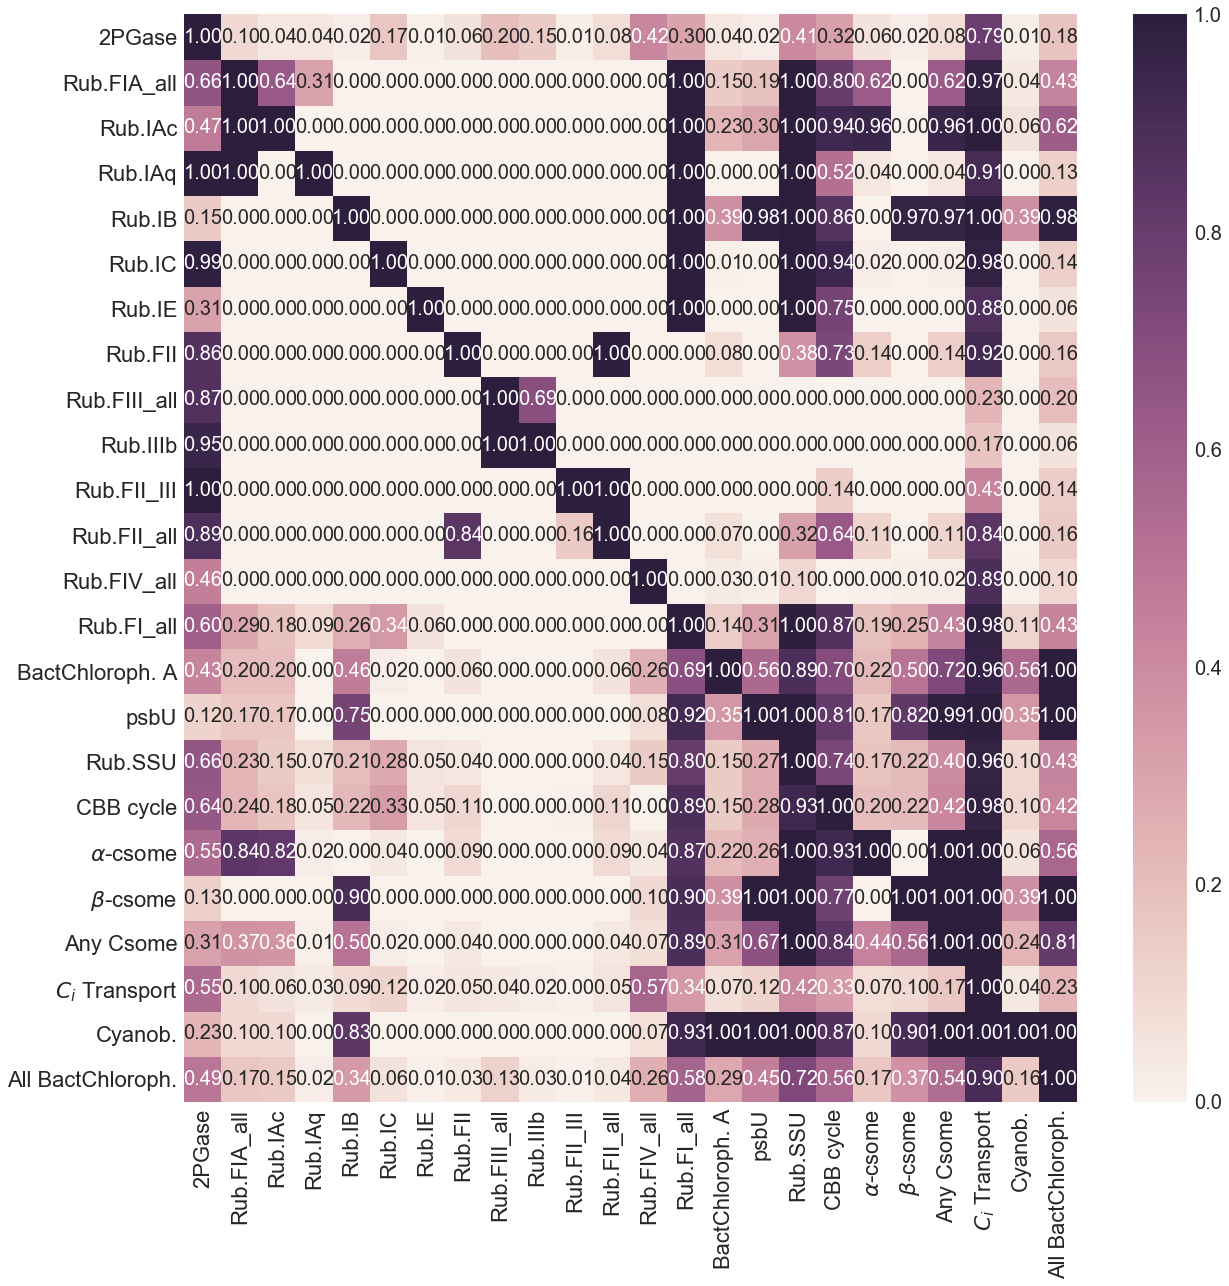

In [70]:
#heatmap of cond prob matrix

###### for rows with no orgs with a given marker, all values will be zero.
###### need to re-code to remove these rows with message instead of including in heat map.
    


#plot heatmap of conditional probabilities
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from os import path
from collections import Counter
from matplotlib import pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial import distance

fig = plt.figure(figsize=(20,20))
sns.set(font_scale=2)
sns.heatmap(condProb_df, annot=True, fmt='.2f', annot_kws={'fontsize': 20}) #, cmap='RdBu_r', center=0.0) changed to fix column order; not sure why this is happening

#tickrange = np.arange(len(ticks)) + 0.5   #i don't know why these lines of code scramble the marker order :Z
#plt.xticks(tickrange, ticks, fontsize=22)
#plt.yticks(tickrange, ticks, fontsize=22, rotation='horizontal')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

plt.savefig("condProb_heatmap.png", dpi=600)

plt.show()


In [41]:
########################################################
# make stacked bar chart of phylogeny by rubisco isoform using FormIA_uni_uni imports from R

#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/bar_stacked.html

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from platform import python_version
print(python_version())  #3.6.1 for Anaconda; 2.7 for conda (terminal interface)

3.6.1


In [50]:
#put copy isoforms of interest from isoform folder to new barcharts folder

path='/Users/tonglen/downloads/rub-co-occurrence-master_2/uniprotKB_downloads/barcharts/'  #a folder with all the ones you want to plot
os.chdir(path)

os.getcwd()

'/Users/tonglen/Downloads/rub-co-occurrence-master_2/uniprotKB_downloads/barcharts'

In [112]:
'''
Make dataframe of Phyla counts and phyla weights for each isoform file in path.
For weights less than 1% of total, aggregate into new 'Other' phylum category.
'''     


#create a list of indices so that the final phylogeny dataframe will include all the taxa,
# even if a phylum is only present in one of the files in the folder and absent from other.

#for phyla:
new=[]
ph_indices = []  #list of phylum indices
filename = ()
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        phylogeny_df = pd.read_csv(filename)  #make a dataframe of each .csv in path
        phylogeny_df.columns = ["Entry", "Entry name", "Gene names", "Gene names  (ORF )", "Organism", "Organism ID", "Length", "Mass", "Sequence", "EC number", "Fragment", "Pathway", "Annotation", "Status", "Intramembrane", "Transmembrane", "Cross reference (INTERPRO)", "Cross reference (PFAM)", "Cross reference (PROSITE)", "Taxonomic lineage (SUPERKINGDOM)", "Phylum", "Class", "Taxonomic lineage (ORDER)", "Cofactor", "Protein names"]
        phylum_sr = round(phylogeny_df.Phylum.value_counts(normalize=True), 3) #get index of phyla 
        new = list(phylum_sr.index.values) #add index to list of total phyla in folder
        ph_indices = list(set(new + ph_indices))
    else:
        continue
phylum_sr

#for class:
new=[]
cl_indices = []  #list of class indices
filename = ()
for filename in os.listdir(path):
    if filename.endswith(".csv"):
        phylogeny_df = pd.read_csv(filename)  #make a dataframe of each .csv in path
        phylogeny_df.columns = ["Entry", "Entry name", "Gene names", "Gene names  (ORF )", "Organism", "Organism ID", "Length", "Mass", "Sequence", "EC number", "Fragment", "Pathway", "Annotation", "Status", "Intramembrane", "Transmembrane", "Cross reference (INTERPRO)", "Cross reference (PFAM)", "Cross reference (PROSITE)", "Taxonomic lineage (SUPERKINGDOM)", "Phylum", "Class", "Taxonomic lineage (ORDER)", "Cofactor", "Protein names"]
        class_sr = round(phylogeny_df.Class.value_counts(normalize=True), 3) #get index of classes
        new = list(class_sr.index.values) #add index to list of total classes in folder
        cl_indices = list(set(new + cl_indices))
    else:
        continue
cl_indices


['Thermoprotei',
 'Ardenticatenia',
 'Chlorobia',
 'Deinococci',
 'Thermococci',
 'Zetaproteobacteria',
 'Hydrogenophilalia',
 'Limnochordia',
 'Thermotogae',
 'Nitrospira',
 'Caldilineae',
 'Chlamydiia',
 'Gloeobacteria',
 'Methanococci',
 'Negativicutes',
 'Thermomicrobia',
 'Archaeoglobi',
 'Acidithiobacillia',
 'Chitinophagia',
 'Nitriliruptoria',
 'Aquificae',
 'Anaerolineae',
 'Halobacteria',
 'Betaproteobacteria',
 'Opitutae',
 'Clostridia',
 'Methanomicrobia',
 'Bacteroidia',
 'Gammaproteobacteria',
 'Methylacidiphilae',
 'Sphingobacteriia',
 'Planctomycetia',
 'Cytophagia',
 'Alphaproteobacteria',
 'Flavobacteriia',
 'Thermoplasmata',
 'Actinobacteria (high G+C Gram-positive bacteria)',
 'Bacilli',
 'Gemmatimonadetes',
 'Deltaproteobacteria']

In [113]:
phylogeny_df = pd.DataFrame()  #re-running cell does not seem to overwrite old arrays as it does in R, so these four lines should hopefully 'blank' these arrays for re-iteration of the cell.
phylum_df = pd.DataFrame()
phylum_sr = pd.Series()
convert_df = pd.DataFrame()
class_sr = pd.Series()



phylum_df = pd.DataFrame(index=ph_indices) #create empty df with index from list of all phyla above

for filename in os.listdir(path): 
    if filename.endswith(".csv"):
        convert_df = pd.DataFrame() #blank the convert_df again for each loop iteration
        phylogeny_df = pd.read_csv(filename)  #make a dataframe of each .csv in path
        phylogeny_df.columns = ["Entry", "Entry name", "Gene names", "Gene names  (ORF )", "Organism", "Organism ID", "Length", "Mass", "Sequence", "EC number", "Fragment", "Pathway", "Annotation", "Status", "Intramembrane", "Transmembrane", "Cross reference (INTERPRO)", "Cross reference (PFAM)", "Cross reference (PROSITE)", "Taxonomic lineage (SUPERKINGDOM)", "Phylum", "Class", "Taxonomic lineage (ORDER)", "Cofactor", "Protein names"]
        phylum_sr = round(phylogeny_df.Phylum.value_counts(normalize=True), 3) #get normalized counts of OTUs per phylum
        convert_df[filename] = phylum_sr #make a dataframe from the phylum_sr column 'filename' (i.e. Form_IV.csv)
        convert_df.rename(columns = {'0': filename})
        phylum_df = pd.concat([phylum_df, convert_df], axis=1)  #axis = 1 causes merge of all the indices across each concatinated column
    else:
        continue

phylum_df
#print(phylum_df.shape) #should have same length as indices above



,FormI_all.csv,FormII_all.csv,FormIII_all.csv,FormIV.csv
Actinobacteria,0.067,0.045,NaN,0.040
Aquificae,NaN,NaN,NaN,0.002
Bacteroidetes,NaN,NaN,NaN,0.036
Balneolaeota,NaN,NaN,NaN,0.002
Chlamydiae,NaN,NaN,NaN,0.002
Chlorobi,NaN,NaN,NaN,0.032
Chloroflexi,0.004,NaN,NaN,0.006
Crenarchaeota,NaN,NaN,0.112,NaN
Cyanobacteria,0.345,NaN,NaN,0.015
Deinococcus-Thermus,0.004,NaN,NaN,0.006


In [78]:
#phylum_df.columns = ['I','II','III','IV']  #rename columns with nice short names
#phylum_df

,I,II,III,IV
Actinobacteria,0.067,0.045,NaN,0.040
Aquificae,NaN,NaN,NaN,0.002
Bacteroidetes,NaN,NaN,NaN,0.036
Balneolaeota,NaN,NaN,NaN,0.002
Chlamydiae,NaN,NaN,NaN,0.002
Chlorobi,NaN,NaN,NaN,0.032
Chloroflexi,0.004,NaN,NaN,0.006
Crenarchaeota,NaN,NaN,0.112,NaN
Cyanobacteria,0.345,NaN,NaN,0.015
Deinococcus-Thermus,0.004,NaN,NaN,0.006


In [114]:
class_df = pd.DataFrame(index=cl_indices) #create empty df with index from list of all classes above
convert_df = pd.DataFrame()  #blank convert_df
for filename in os.listdir(path): 
    if filename.endswith(".csv"):
        convert_df = pd.DataFrame() #blank the convert_df again for each loop iteration
        phylogeny_df = pd.read_csv(filename)  #make a dataframe of each .csv in path
        phylogeny_df.columns = ["Entry", "Entry name", "Gene names", "Gene names  (ORF )", "Organism", "Organism ID", "Length", "Mass", "Sequence", "EC number", "Fragment", "Pathway", "Annotation", "Status", "Intramembrane", "Transmembrane", "Cross reference (INTERPRO)", "Cross reference (PFAM)", "Cross reference (PROSITE)", "Taxonomic lineage (SUPERKINGDOM)", "Phylum", "Class", "Taxonomic lineage (ORDER)", "Cofactor", "Protein names"]
        class_sr = round(phylogeny_df.Class.value_counts(normalize=True), 3) #get normalized counts of OTUs per phylum
        convert_df[filename] = class_sr #make a dataframe from the class_sr column 'filename' (i.e. Form_IV.csv)
        convert_df.rename(columns = {'0': filename})
        class_df = pd.concat([class_df, convert_df], axis=1)  #axis = 1 causes merge of all the indices across each concatinated column
    else:
        continue

class_df
#print(phylum_df.shape) #should have same length as indices above

#consolidate all classes except proteobacteria into 'other'
class_df = class_df.loc[['Alphaproteobacteria', 'Betaproteobacteria', 'Gammaproteobacteria', 'Deltaproteobacteria', 'Epsilonproteobacteria', 'Zetaproteobateria', 'Ca. Lambdaproteobacteria', 
'Ca. Muproteobacteria', 'Acidithiobacillia', 'Hydrogenophilalia', 'Oligoflexia',]]

#class_df = class_df.rename_axis(['*Alphaproteobacteria', '*Betaproteobacteria', '*Gammaproteobacteria', '*Deltaproteobacteria', '*Epsilonproteobacteria', '*Zetaproteobateria', '*Ca. Lambdaproteobacteria', 
#'*Ca. Muproteobacteria', '*Acidithiobacillia', '*Hydrogenophilalia', '*Oligoflexia',], axis = 'rows')

a = 0
a = class_df.sum(axis = 0, skipna = True)  # a is list of the sums of class weights of proteob.

total = pd.DataFrame(a, index=class_df.columns, columns =['Total'])  #it wouldn't let me switch rows and columns here for some reason
total = total.transpose()
m = class_df < 0.01  #convert weights less than 0.01 to NaN for all elements in class_df
class_df = class_df.mask(m)  
class_df = pd.DataFrame.dropna(class_df, how='all')  #drop the rows that only have NaN


#class_df.columns = ['I','II','III','IV']  #rename columns with nice short names
class_df

,FormI_all.csv,FormII_all.csv,FormIII_all.csv,FormIV.csv
Alphaproteobacteria,0.343,0.273,NaN,0.207
Betaproteobacteria,0.296,0.250,NaN,0.105
Gammaproteobacteria,0.183,0.136,NaN,0.048
Deltaproteobacteria,NaN,0.045,NaN,NaN
Acidithiobacillia,0.012,0.045,NaN,NaN


In [115]:
#Frac_df gives the fraction of total proteobacteria phylum for each class listed.
for i in a:
    frac_df = class_df / a  


frac_df


,FormI_all.csv,FormII_all.csv,FormIII_all.csv,FormIV.csv
Alphaproteobacteria,0.408333,0.364486,NaN,0.571823
Betaproteobacteria,0.352381,0.333778,NaN,0.290055
Gammaproteobacteria,0.217857,0.181575,NaN,0.132597
Deltaproteobacteria,NaN,0.060080,NaN,NaN
Acidithiobacillia,0.014286,0.060080,NaN,NaN


In [116]:
#apply frac_df to the proteobacteria class weight for each isoform:
proteob = phylum_df.loc['Proteobacteria']  #list of proteob weights
proteob

FormI_all.csv      0.557
FormII_all.csv     0.795
FormIII_all.csv      NaN
FormIV.csv         0.353
Name: Proteobacteria, dtype: float64

In [117]:
for i in proteob:
    proteob_df = frac_df*proteob
proteob_df     # has weighted values of classes within the proteob phylum weight

phylum_df = phylum_df.append(proteob_df)  #append phylum df to proteob class df
#masked_df=masked_df.sort_index()

# consolidate low weights to new 'Other' phylum
weight = 0
other = []   # list to assign the sum of low weights from each column
for column in phylum_df:
    weight = 0
    column_sr = phylum_df[column] 
    for i in column_sr.values:   #create series of column contents by column name using [] operator
        if i < 0.01:
            weight += i
        else:
            continue
    other.append(weight)     #add low weight to other 
other


df = pd.DataFrame(other, index=phylum_df.columns, columns =['Other'])  #it wouldn't let me switch rows and columns here for some reason
df = df.transpose()
df

masked_df = pd.DataFrame(phylum_df)  #make a copy of phylum_df so i don't have to remake it each time i run this cell
masked_df = masked_df.append(df)   #add the 'other' row


m = masked_df < 0.01  #convert weights less than 0.01 to NaN for all elements in df
masked_df = masked_df.mask(m)

masked_df = pd.DataFrame.dropna(masked_df, how='all')  #get rid of rows that are blank in each column
masked_df.columns.name = 'Isoforms'  #give the dataframe some handles for the plot function to use
masked_df.index.name = 'Phyla'
masked_df = masked_df.drop(['Proteobacteria'], axis='rows')
masked_df
#check that sums of each column weights is = 1:
check_sum = masked_df.sum(axis = 0, skipna = True)

print(check_sum)
masked_df

Isoforms
FormI_all.csv      0.997021
FormII_all.csv     0.999000
FormIII_all.csv    1.000000
FormIV.csv         0.995050
dtype: float64


Isoforms,FormI_all.csv,FormII_all.csv,FormIII_all.csv,FormIV.csv
Phyla,,,,
Actinobacteria,0.067000,0.045000,NaN,0.040000
Bacteroidetes,NaN,NaN,NaN,0.036000
Chlorobi,NaN,NaN,NaN,0.032000
Crenarchaeota,NaN,NaN,0.112,NaN
Cyanobacteria,0.345000,NaN,NaN,0.015000
Euryarchaeota,NaN,0.159000,0.862,0.036000
Firmicutes,0.012000,NaN,0.026,0.440000
Nitrospirae,NaN,NaN,NaN,0.015000
Verrucomicrobia,0.012000,NaN,NaN,NaN


In [104]:
#masked_df.rename(columns={"A": "a", "B": "c"})
#masked_df.rename(columns ={"FormI_all.csv": "I", "FormII_all.csv": "II", "FormIII_all.csv":"III", "FormIV_all.csv":"IV"})  
#masked_df.columns.name = 'Isoforms'  
#masked_df.shape
#masked_df

Phyla,Actinobacteria,Bacteroidetes,Chlorobi,Crenarchaeota,Cyanobacteria,Euryarchaeota,Firmicutes,Nitrospirae,Verrucomicrobia,Alphaproteobacteria,Betaproteobacteria,Gammaproteobacteria,Deltaproteobacteria,Acidithiobacillia,Other
I,0.067,NaN,NaN,NaN,0.345,NaN,0.012,NaN,0.012,0.227442,0.196276,0.121346,NaN,NaN,0.015957
II,0.045,NaN,NaN,NaN,NaN,0.159,NaN,NaN,NaN,0.289766,0.265354,0.144352,0.047764,0.047764,NaN
III,NaN,NaN,NaN,0.112,NaN,0.862,0.026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IV,0.040,0.036,0.032,NaN,0.015,0.036,0.440,0.015,NaN,0.201854,0.102390,0.046807,NaN,NaN,0.030000


In [119]:
#plot all the things! try to reverse direction of stacks so colors are same order as legend

import numpy as np
import pandas as pd
import matplotlib.pyplot as plot


masked_df = masked_df.transpose()#flip some shit so that there is one bar per isoform: pivot() is used for flipping three columns
masked_df

Isoforms,FormI_all.csv,FormII_all.csv,FormIII_all.csv,FormIV.csv
Phyla,,,,
Actinobacteria,0.067000,0.045000,NaN,0.040000
Bacteroidetes,NaN,NaN,NaN,0.036000
Chlorobi,NaN,NaN,NaN,0.032000
Crenarchaeota,NaN,NaN,0.112,NaN
Cyanobacteria,0.345000,NaN,NaN,0.015000
Euryarchaeota,NaN,0.159000,0.862,0.036000
Firmicutes,0.012000,NaN,0.026,0.440000
Nitrospirae,NaN,NaN,NaN,0.015000
Verrucomicrobia,0.012000,NaN,NaN,NaN


In [126]:
masked_df.rename(columns ={"FormI_all.csv": "I", "FormII_all.csv": "II", "FormIII_all.csv":"III", "FormIV.csv":"IV"}, inplace=True)  
masked_df.columns.name = 'Isoforms'  
#print(masked_df.shape)
masked_df

Isoforms,I,II,III,IV
Phyla,,,,
Actinobacteria,0.067000,0.045000,NaN,0.040000
Bacteroidetes,NaN,NaN,NaN,0.036000
Chlorobi,NaN,NaN,NaN,0.032000
Crenarchaeota,NaN,NaN,0.112,NaN
Cyanobacteria,0.345000,NaN,NaN,0.015000
Euryarchaeota,NaN,0.159000,0.862,0.036000
Firmicutes,0.012000,NaN,0.026,0.440000
Nitrospirae,NaN,NaN,NaN,0.015000
Verrucomicrobia,0.012000,NaN,NaN,NaN


In [128]:
#no idea why it works when I only use the first column as a data series. :Z

masked_df.groupby('Isoforms', axis=1)['Actinobacteria']\
    .value_counts()\
    .unstack(level=1)\
    .plot.bar(stacked=True)
#Note: .loc[:,['Jan','Feb', 'Mar']] is used here to rearrange the layer ordering below:
masked_df.plot.bar(stacked=True, figsize=(10,7))

plot.ylabel('Normalized abundance')
plot.legend(bbox_to_anchor=(1.1, 1.05))

#plot.tight_layout()
plot.subplots_adjust(right=0.7, bottom = 0.3)
plot.savefig("barplot_phyla.png", dpi=600)

plot.show()

KeyError: 'Isoforms'

In [271]:
###################### scratch code for calculating condProb from base functions ##################


#show the rows that have markers for intersect and for individual marker:
#count = 0
#markers = ['A', 'B', 'C', 'D']
#while len(markers) > count+1:


count = 0
while len(markers) > count:  #iterate through column indexes
    intersect = df[(df.iloc[:,0]>0) & (df.iloc[:,(count)]>0)]  #get num columns with A and B greater than zero
    denom = df[df.iloc[:,0]>0]  #get number of columns with A greater than 0
    print (intersect)
    print (denom)
    print("count =", count)
    count += 1

           A         B         C         D
3   0.421970 -0.376728  0.243596 -0.392574
8   0.205050  0.315869  0.046618 -0.476660
12  0.205137  0.405267  0.488305 -0.221015
13  0.016507 -0.283883 -0.731968 -0.151958
14  0.348394 -0.139392 -1.811962 -1.725486
15  0.300775  0.177158  1.617966 -0.052439
19  0.661121  1.608715 -1.276547 -0.471401
           A         B         C         D
3   0.421970 -0.376728  0.243596 -0.392574
8   0.205050  0.315869  0.046618 -0.476660
12  0.205137  0.405267  0.488305 -0.221015
13  0.016507 -0.283883 -0.731968 -0.151958
14  0.348394 -0.139392 -1.811962 -1.725486
15  0.300775  0.177158  1.617966 -0.052439
19  0.661121  1.608715 -1.276547 -0.471401
count = 0
           A         B         C         D
8   0.205050  0.315869  0.046618 -0.476660
12  0.205137  0.405267  0.488305 -0.221015
15  0.300775  0.177158  1.617966 -0.052439
19  0.661121  1.608715 -1.276547 -0.471401
           A         B         C         D
3   0.421970 -0.376728  0.243596 -0.392574
8

In [272]:
#for i in markers:
count = 0
while len(markers) > count:  #iterate through column indexes
    intersect = len(df[(df.iloc[:,0]>0) & (df.iloc[:,(count)]>0)])  #get num columns with A and B greater than zero
    denom = len(df[df.iloc[:,0]>0])  #get number of columns with A greater than 0
    print (round(intersect/denom, 3))
    count += 1


1.0
0.571
0.571
0.0


In [273]:
#get num rowns and num cols of data frame as list of integers:

rows = [i for i in range(df.shape[0])]
cols = [i for i in range(df.shape[1])]
print(rows)
print(cols)

#the number of rows only use df.shape[0] and for the number of columns only use: df.shape[1]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
[0, 1, 2, 3]


In [274]:
#count = 0
#while len(entries) > count:  #iterate through column indexes
#    intersect = len(df[(df.iloc[:,0]>0) & (df.iloc[:,(count)]>0)])  #get num columns with A and B greater than zero
#    marker = len(df[df.iloc[:,0]>0])  #get number of columns with A greater than 0
#    print (round(intersect/marker, 3))
#    count += 1
#

# try to get two separate counters, one for numerator and one for denominator.
num = 0
denom = 0
for i in cols:
    print("row num ",i)
    num = 0
    for i in cols:  #iterate through column indexes
            intersect = len(df[(df.iloc[:,(denom)]>0) & (df.iloc[:,(num)]>0)])  #get num columns with A and B greater than zero
            cond = len(df[df.iloc[:,(denom)]>0])  #get number of columns with A greater than 0; i.e. the condition
            print (round(intersect/cond, 3))
            num += 1
            print("col num ",i)
    denom +=1

row num  0
1.0
col num  0
0.571
col num  1
0.571
col num  2
0.0
col num  3
row num  1
0.364
col num  0
1.0
col num  1
0.545
col num  2
0.182
col num  3
row num  2
0.364
col num  0
0.545
col num  1
1.0
col num  2
0.364
col num  3
row num  3
0.0
col num  0
0.333
col num  1
0.667
col num  2
1.0
col num  3


In [275]:
#ermahgerd it werked!!!! :^D
#now try to append to a new dt\ataframe so i can make pretty heat-map
# DataFrame.append(other, ignore_index=False, verify_integrity=False, sort=None)  function for adding row to existing dataframe
#

#condProb_df = pd.DataFrame(students, columns = ['Name' , 'Age', 'City' , 'Country'], index=['a', 'b', 'c' , 'd' , 'e' , 'f']) 
condProb_df = pd.DataFrame(df, columns = markers, index = markers) #df exists as defined dataframe above; weird it didn't fill in the values of df
print(condProb_df)

    A   B   C   D
A NaN NaN NaN NaN
B NaN NaN NaN NaN
C NaN NaN NaN NaN
D NaN NaN NaN NaN


In [276]:




num = 0  #counter for numerator column; numerator is intersection of two markers
denom = 0  #counter for denominator column; denominator is conditional marker (i.e. A when 'given A, what is prob B)
for i in cols:
    num = 0 
    print ('row num = ', i)
    data = []  #make / overwrite an empty list called 'data' that will eventually contain one row of condProbs
    for i in cols:  #iterate through column indexes
        intersect = len(df[(df.iloc[:,(denom)]>0) & (df.iloc[:,(num)]>0)])  #get num columns with A and B greater than zero
        cond = len(df[df.iloc[:,(denom)]>0])  #get denominator greater than 0, i.e. the conditional case
        calc = (round(intersect/cond, 3))  #calculate conditional prob at one cell location
        data.append(calc) #add cell value to list of values for that new row
        print("col num ",i)
        print(data)
        num += 1
    condProb_df.iloc[denom] = data #append condProb_df with data, the list of new row of values at location according to denominator counter
    denom +=1 
    
print(condProb_df)   

# Add a new row at index position 2 with values provided in list
#dfObj.iloc[2] = ['Smriti', 26, 'Bangalore', 'India']

row num =  0
col num  0
[1.0]
col num  1
[1.0, 0.571]
col num  2
[1.0, 0.571, 0.571]
col num  3
[1.0, 0.571, 0.571, 0.0]
row num =  1
col num  0
[0.364]
col num  1
[0.364, 1.0]
col num  2
[0.364, 1.0, 0.545]
col num  3
[0.364, 1.0, 0.545, 0.182]
row num =  2
col num  0
[0.364]
col num  1
[0.364, 0.545]
col num  2
[0.364, 0.545, 1.0]
col num  3
[0.364, 0.545, 1.0, 0.364]
row num =  3
col num  0
[0.0]
col num  1
[0.0, 0.333]
col num  2
[0.0, 0.333, 0.667]
col num  3
[0.0, 0.333, 0.667, 1.0]
       A      B      C      D
A  1.000  0.571  0.571  0.000
B  0.364  1.000  0.545  0.182
C  0.364  0.545  1.000  0.364
D  0.000  0.333  0.667  1.000


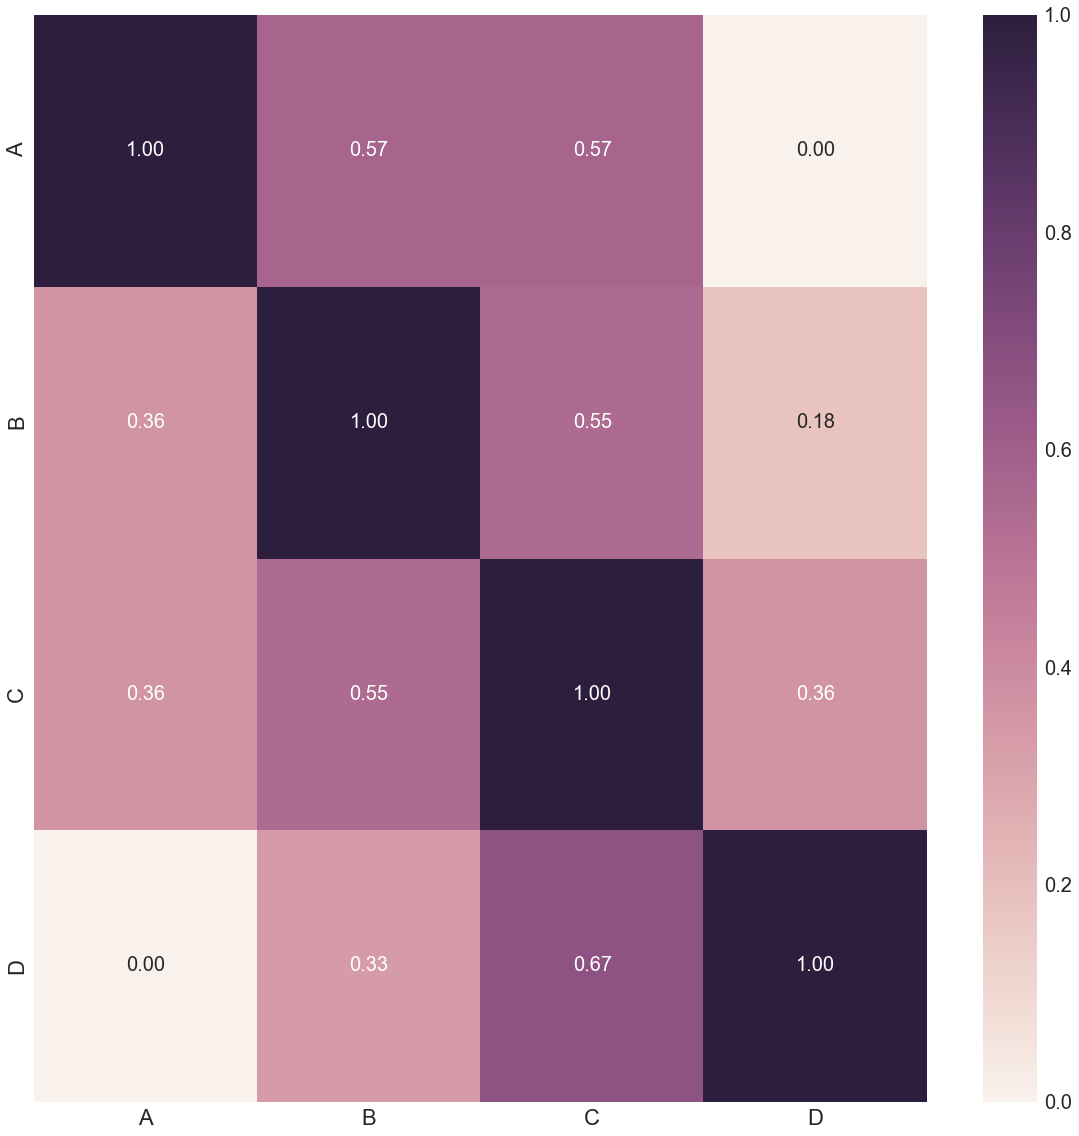

In [277]:
#plot heatmap of conditional probabilities
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from os import path
from collections import Counter
from matplotlib import pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial import distance

fig = plt.figure(figsize=(20,20))
sns.set(font_scale=2)
sns.heatmap(condProb_df, annot=True, annot_kws={'fontsize': 20}, fmt='.2f') #, cmap='RdBu_r', center=0.0) changed to fix column order; not sure why this is happening

#tickrange = np.arange(len(ticks)) + 0.5
#plt.xticks(tickrange, ticks, fontsize=22)
#plt.yticks(tickrange, ticks, fontsize=22, rotation='horizontal')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)

#plt.savefig("condProb_heatmap.png", dpi=600)

plt.show()

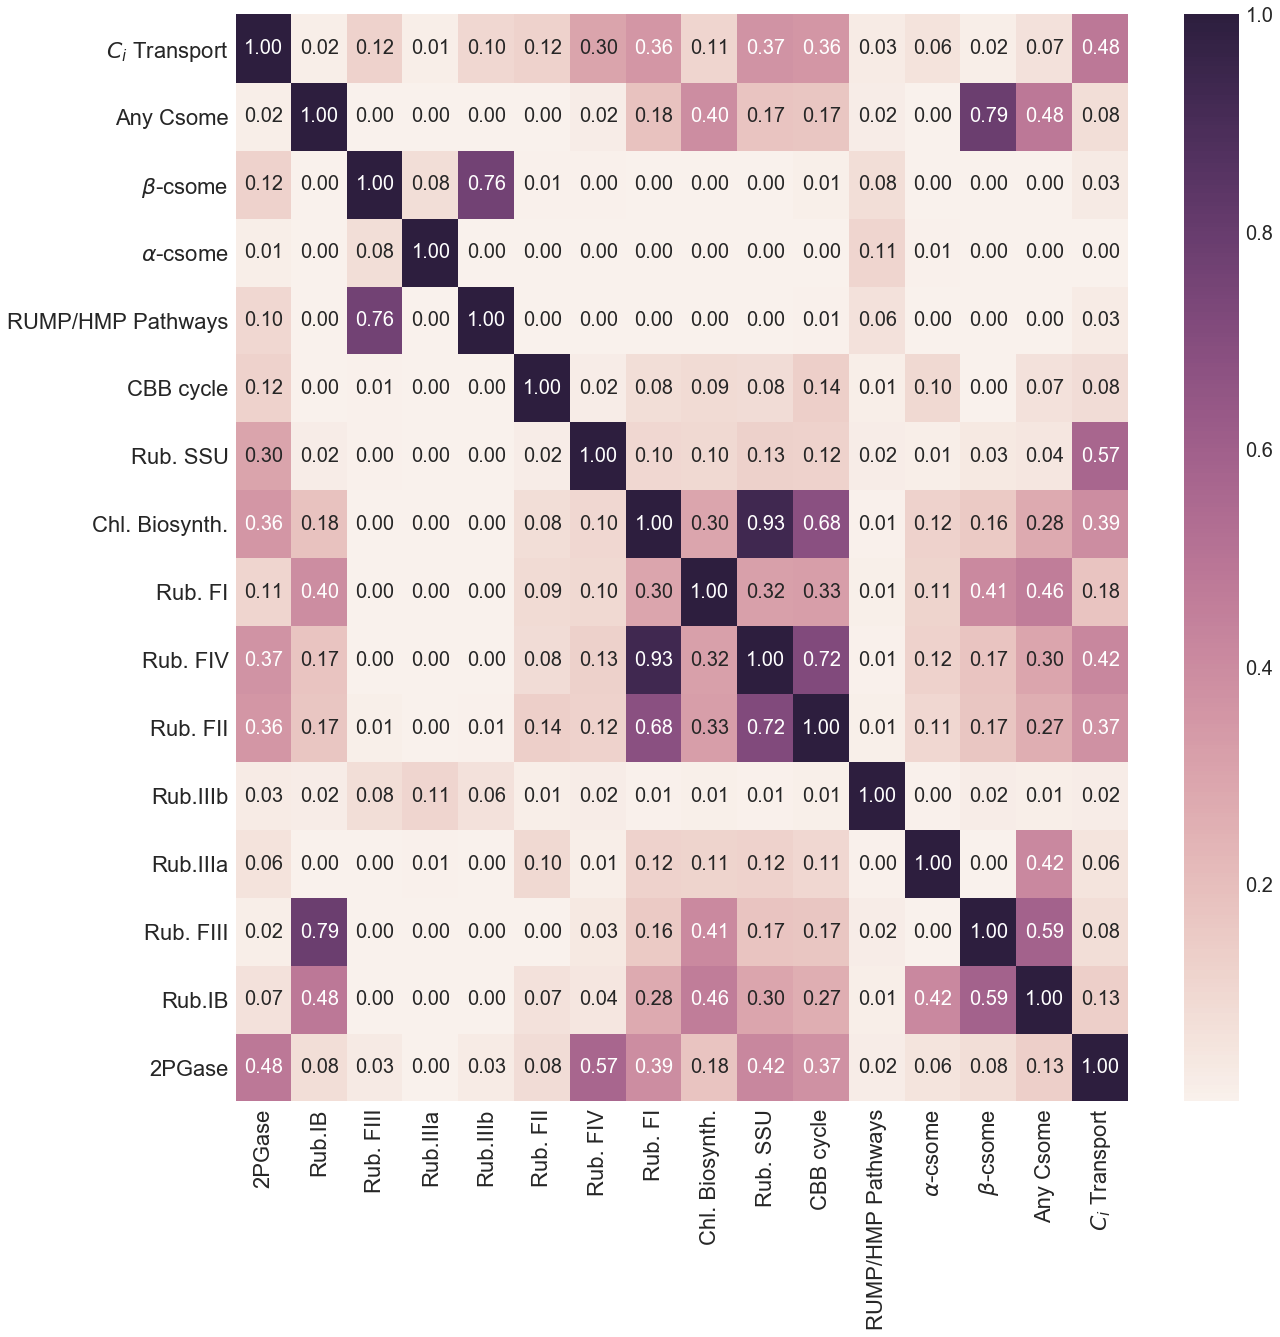

In [21]:
# plot a Jaccard heatmap
fig = plt.figure(figsize=(20,20))
sns.set(font_scale=2)  #added during troubleshooting
sns.heatmap(jacc_sim_DF, annot=True, annot_kws={'fontsize': 20}, fmt='.2f')
tickrange = np.arange(len(ticks)) + 0.5
plt.xticks(tickrange, ticks, fontsize=22)
plt.yticks(tickrange, ticks, fontsize=22)
#plt.yticks(tickrange, ticks, fontsize=22, rotation='horizontal')

#heres the pearson heatmap code for comparison, as it's plotting correctly:
    #fig = plt.figure(figsize=(20,20))
    #sns.set(font_scale=2)
    #sns.heatmap(corr, annot=True, annot_kws={'fontsize': 20}, fmt='.2f')#, cmap='RdBu_r', center=0.0) #removed to correct issue with column order

#from documentation example: https://seaborn.pydata.org/generated/seaborn.heatmap.html
#flights = sns.load_dataset("flights")
#flights = flights.pivot("month", "year", "passengers")
#ax = sns.heatmap(flights)

plt.savefig("jaccard_heatmap.png", dpi=600)
plt.show()

In [ ]:
# Calculate pairwise jaccard similarities from jaccard distances.
jacc_sim = 1.0 - pairwise_distances(for_corr.T, metric="jaccard")
# Convert to dataframe
jacc_sim_DF = pd.DataFrame(jacc_sim, columns=for_corr.columns, index=for_corr.columns)
jacc_sim_DF